Using device: cuda


Ours TD3 Pendulum-v1:   0%|          | 0/100 [00:00<?, ?ep/s]

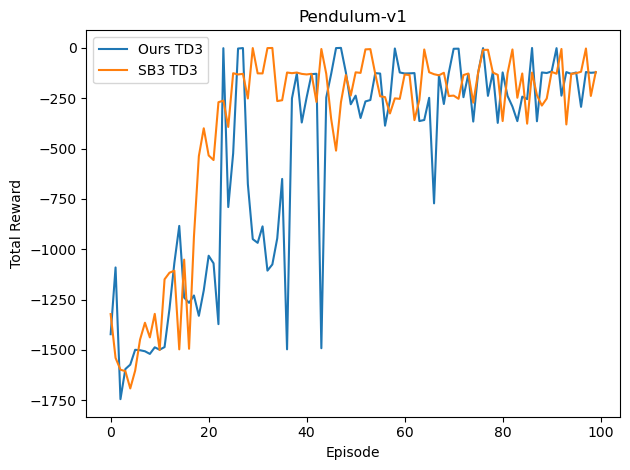

In [7]:
#!/usr/bin/env python3
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import gymnasium as gym_sb3
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from stable_baselines3 import TD3 as SB3_TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# --------------------------------------------------------------------------- #
# Fix all seeds for reproducibility
# --------------------------------------------------------------------------- #
base_seed = 12345
random.seed(base_seed)
np.random.seed(base_seed)
torch.manual_seed(base_seed)
torch.cuda.manual_seed_all(base_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# --------------------------------------------------------------------------- #
# Device (GPU if available)
# --------------------------------------------------------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------------------- #
# Replay Buffer: stores transitions for off-policy learning
# --------------------------------------------------------------------------- #
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim):
        self.capacity = capacity
        self.obs_buf      = np.zeros((capacity, obs_dim),      dtype=np.float32)
        self.next_obs_buf = np.zeros((capacity, obs_dim),      dtype=np.float32)
        self.acts_buf     = np.zeros((capacity, act_dim),      dtype=np.float32)
        self.rews_buf     = np.zeros((capacity,),              dtype=np.float32)
        self.done_buf     = np.zeros((capacity,),              dtype=np.float32)
        self.ptr, self.size = 0, 0

    def push(self, obs, act, rew, next_obs, done):
        """
        Add a transition to the buffer, overwriting oldest when full.
        """
        self.obs_buf[self.ptr]      = obs
        self.acts_buf[self.ptr]     = act
        self.rews_buf[self.ptr]     = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr]     = done
        # advance pointer and track size
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """
        Uniformly sample a batch of transitions and convert to torch tensors.
        """
        idxs = np.random.randint(0, self.size, size=batch_size)
        obs      = torch.tensor(self.obs_buf[idxs],      device=device)
        acts     = torch.tensor(self.acts_buf[idxs],     device=device)
        next_obs = torch.tensor(self.next_obs_buf[idxs], device=device)
        rews     = torch.tensor(self.rews_buf[idxs],     device=device).unsqueeze(-1)
        dones    = torch.tensor(self.done_buf[idxs],     device=device).unsqueeze(-1)
        return obs, acts, next_obs, rews, dones

    def __len__(self):
        return self.size

# --------------------------------------------------------------------------- #
# Actor network: maps state to action deterministically
# --------------------------------------------------------------------------- #
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        # two hidden layers of 256 units
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        # forward pass through hidden layers with ReLU
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        # final tanh and scale to action range
        return self.max_action * torch.tanh(self.l3(a))

# --------------------------------------------------------------------------- #
# Critic network: two Q-value heads to mitigate overestimation
# --------------------------------------------------------------------------- #
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)
        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        # concatenate state and action
        sa = torch.cat([state, action], 1)
        # Q1
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        # Q2
        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        # single-Q head for computing actor loss
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        return self.l3(q1)

# --------------------------------------------------------------------------- #
# TD3 Agent: orchestrates networks, targets, and learning
# --------------------------------------------------------------------------- #
class TD3Agent:
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2):
        # actor and target actor
        self.actor        = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_opt    = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        # critic and target critic
        self.critic        = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_opt    = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        # hyperparameters
        self.max_action   = max_action
        self.discount     = discount
        self.tau          = tau
        self.policy_noise = policy_noise
        self.noise_clip   = noise_clip
        self.policy_freq  = policy_freq
        self.total_it     = 0

    def select_action(self, state):
        """
        Deterministically select action from current policy.
        """
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        """
        Perform one TD3 update given a batch from the replay buffer.
        - Critic update using clipped double Q-learning
        - Delayed actor (policy) update every policy_freq steps
        - Soft updates of target networks
        """
        self.total_it += 1

        # 1) Sample a batch of transitions
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        # 2) Compute target Q-value
        with torch.no_grad():
            # a) add clipped noise to target action (target policy smoothing)
            noise = (torch.randn_like(action) * self.policy_noise)
            noise = noise.clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)

            # b) target Q-values from frozen networks
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * self.discount * target_Q

        # 3) Get current Q estimates and compute critic loss
        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # optimize critic
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        # 4) Delayed policy updates
        if self.total_it % self.policy_freq == 0:
            # a) actor loss (maximizes Q)
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            # optimize actor
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            # b) soft update targets
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# --------------------------------------------------------------------------- #
# Callback for Stable Baselines3 to log episode rewards
# --------------------------------------------------------------------------- #
class EpisodeRewardLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []
    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.rewards.append(info["episode"]["r"])
        return True

# --------------------------------------------------------------------------- #
# Training our TD3 implementation
# --------------------------------------------------------------------------- #
def train_ours_td3(env_id, episodes, batch_size, grad_steps=1, prefill=0):
    env = gym.make(env_id)
    env.seed(base_seed)
    env.action_space.seed(base_seed)
    max_steps    = getattr(env, "_max_episode_steps", env.spec.max_episode_steps)
    state_dim    = env.observation_space.shape[0]
    action_dim   = env.action_space.shape[0]
    max_action   = float(env.action_space.high[0])

    agent  = TD3Agent(state_dim, action_dim, max_action)
    buffer = ReplayBuffer(int(1e6), state_dim, action_dim)

    # Prefill buffer with random actions for initial stability
    if prefill > 0:
        obs = env.reset()
        for _ in range(prefill):
            a = env.action_space.sample()
            next_obs, r, d, _ = env.step(a)
            buffer.push(obs, a, r, next_obs, float(d))
            obs = next_obs if not d else env.reset()

    returns = []
    for ep in tqdm(range(episodes), desc=f"Ours TD3 {env_id}", unit="ep"):
        obs, ep_ret = env.reset(), 0.0
        for _ in range(max_steps):
            # select action and step
            action = agent.select_action(np.array(obs))
            next_obs, reward, done, _ = env.step(action)
            buffer.push(obs, action, reward, next_obs, float(done))
            obs = next_obs
            ep_ret += reward

            # only update once buffer has enough samples
            if len(buffer) > batch_size:
                for _ in range(grad_steps):
                    agent.train(buffer, batch_size)
            if done:
                break
        returns.append(ep_ret)
    return returns

# --------------------------------------------------------------------------- #
# Training SB3's built-in TD3 for comparison
# --------------------------------------------------------------------------- #
def train_sb3_td3(env_id, episodes):
    env0    = gym_sb3.make(env_id)
    env_sb3 = Monitor(env0)
    env_sb3.reset(seed=base_seed)
    env_sb3.action_space.seed(base_seed)

    max_steps = getattr(env_sb3.env, "_max_episode_steps", env_sb3.env.spec.max_episode_steps)
    total_ts  = episodes * max_steps

    model  = SB3_TD3("MlpPolicy", env_sb3, verbose=0, seed=base_seed, device=device)
    logger = EpisodeRewardLogger()
    model.learn(total_timesteps=total_ts, callback=logger)
    # return one reward per episode
    return logger.rewards[:episodes]

# --------------------------------------------------------------------------- #
# Main: train and plot both agents on Pendulum and MountainCarContinuous
# --------------------------------------------------------------------------- #
def main():
    configs = [
        ("Pendulum-v1",              100, 256, 1, 1000),
        # ("MountainCarContinuous-v0", 50, 256, 1, 1000),
    ]
    for env_id, episodes, batch_size, grad_steps, prefill in configs:
        ours = train_ours_td3(env_id, episodes, batch_size, grad_steps, prefill)
        sb3  = train_sb3_td3(env_id, episodes)

        plt.figure()
        plt.plot(ours, label="Ours TD3")
        plt.plot(sb3,  label="SB3 TD3")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title(env_id)
        plt.legend()
        plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    main()
